In [ ]:
import torch
import torch.nn as nn
import foolbox as fb
from robustbench.utils import load_model
from robustbench.data import load_cifar10
from foolbox.models.pytorch import PyTorchModel
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
x_test, y_test = load_cifar10(n_examples=100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

Using device: cuda


c:\Users\balaj\miniconda3\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [ ]:
surrogate1 = load_model(model_name='Standard', dataset='cifar10', threat_model='Linf').to(device).eval()

In [ ]:
class LogitEnsemble(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models)
    def forward(self, x):
        return torch.mean(torch.stack([m(x) for m in self.models]), dim=0)

In [ ]:
ensemble_model = LogitEnsemble([surrogate1]).to(device).eval()
fmodel = PyTorchModel(ensemble_model, bounds=(0, 1), device=device)
attack = fb.attacks.LinfPGD(rel_stepsize=0.1, steps=20)

In [ ]:
_, adv_images, success = attack(fmodel, x_test.to(device), y_test.to(device), epsilons=[8/255])
adv_batch = adv_images[0]

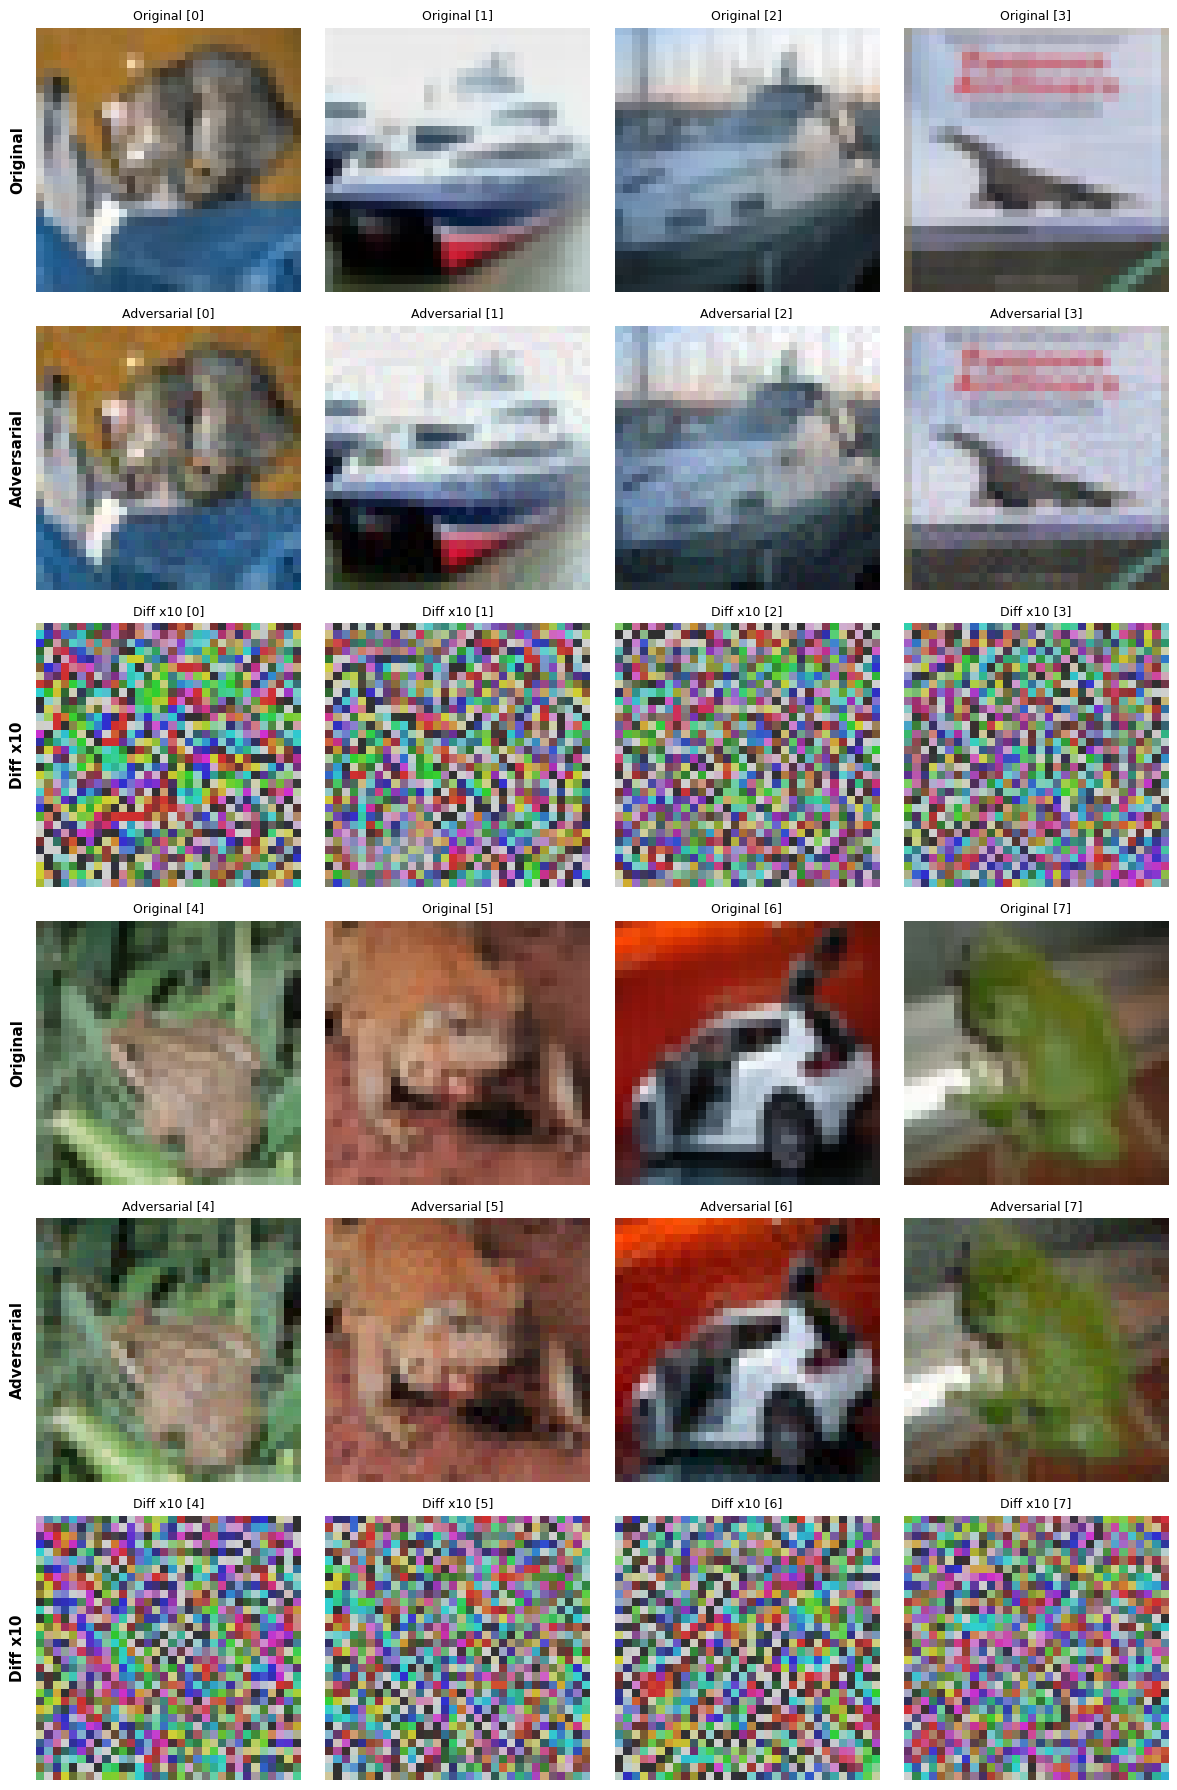

In [ ]:
def imshow(ax, img_tensor, title=""):
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(title, fontsize=9)
    ax.axis('off')

n = 8
cols = 4
n_groups = math.ceil(n / cols)
row_labels = ["Original", "Adversarial", "Diff x10"]

fig, axes = plt.subplots(3 * n_groups, cols, figsize=(3 * cols, 9 * n_groups))

for i in range(n):
    g = i // cols
    c = i % cols
    ro = g * 3

    imshow(axes[ro + 0, c], x_test[i], f"Original [{i}]")
    imshow(axes[ro + 1, c], adv_batch[i], f"Adversarial [{i}]")
    diff = (adv_batch[i] - x_test[i].to(adv_batch.device))
    diff = (diff * 10 + 0.5).clamp(0, 1)
    imshow(axes[ro + 2, c], diff, f"Diff x10 [{i}]")

for g in range(n_groups):
    for r, label in enumerate(row_labels):
        ax = axes[g * 3 + r, 0]
        ax.set_ylabel(label, fontsize=11, fontweight='bold', labelpad=8)
        ax.axis('on')
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        for spine in ax.spines.values():
            spine.set_visible(False)

plt.tight_layout()
plt.show()


In [31]:
target_model_names = [
    'Wang2023Better_WRN-28-10', 
    'Gowal2020Uncovering_28_10_extra', 
    'Carmon2019Unlabeled'
]

In [ ]:
for name in target_model_names:
    target_model = load_model(model_name=name, dataset='cifar10', threat_model='Linf').to(device).eval()
    
    with torch.no_grad():
        outputs = target_model(adv_batch)
        acc = (outputs.argmax(1) == y_test.to(device)).float().mean()
    
    print(f"Model: {name} | Transfer Robust Accuracy: {acc.item()*100:.2f}%")

Model: Wang2023Better_WRN-28-10 | Transfer Robust Accuracy: 93.00%
Model: Gowal2020Uncovering_28_10_extra | Transfer Robust Accuracy: 88.00%
Model: Carmon2019Unlabeled | Transfer Robust Accuracy: 89.00%
